# Machine Learning project

# Sentiment Analysis of IMDB Movie Reviews using PySpark

## Abstract
The project presents a large-scale emotion analysis task on the IMDB movie review dataset using Pyspark. The dataset has 50,000 movie reviews labeled as positive or negative. We apply many machine learning algorithms (logistics Region, Bhole Bayes, Random Forest and Relative Support Vector Classifier) and compare their performance. Pyspark enables distributed processing, which makes it suitable for handling the text data on a large scale. The pipeline includes text preprocessing (cleaning, tokanization, stopWords removal), feature extraction TF-IDF and extraction using classifications. Results suggest that linear models such as logistic region and SVMs receive higher accuracy than possible or ensemble approaches. This report discusses functioning, literature background, experimental results and future improvements.


In [ ]:
# First we import python utilities and helper modules for file handling.
# They need to be unzipped and Spark can process it before preparing the IMDB dataset.

import zipfile
import os

v_zi_pa = "/content/muy.zip"

v_ex_di = "/content/extracted_files"
os.makedirs(v_ex_di, exist_ok=True)

with zipfile.ZipFile(v_zi_pa, 'r') as v_zi_re:
    v_zi_re.extractall(v_ex_di)

print(f"Extracted to: {v_ex_di}")

Extracted to: /content/extracted_files


In [ ]:
# Here we install Pyspark 3.4.1 and bring Ml to libraries.
# This ensures that we have the right environment for pipelines and ML tools.

!pip install pyspark==3.4.1
!pip install spark-nlp==5.2.3

import os
import re
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression, NaiveBayes, RandomForestClassifier, LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#  - Data Loading and Preprocessing

In [ ]:
# A small function Gettext (path) is defined to read lessons from review files.
# It helps us load the raw review material in memory in a re -purpose manner.

# --- Fix helpers: keep same logic, ensure they return lists ---

import os

def v_ge(v_pa):
    """Collect file paths under v_pa."""
    v_li = []
    for v_d, _, v_fs in os.walk(v_pa):
        for v_f in v_fs:
            v_li.append(os.path.join(v_d, v_f))
    return v_li  # <-- important

def v_da(v_ar, v_la):
    """Read files in v_ar and attach label v_la -> list of (text, label)."""
    v_li = []
    for v_p in v_ar:
        with open(v_p, encoding="utf-8", errors="ignore") as v_f:
            v_tx = v_f.read()
        v_li.append((v_tx, v_la))
    return v_li  # <-- important


In [ ]:
# Training and test folders (POS/Neg) paths are set here.
# Clear structure makes it easy to load the data correctly.
v_po_pa = '/content/extracted_files/aclImdb_v1/aclImdb/train/pos'
v_ne_pa = '/content/extracted_files/aclImdb_v1/aclImdb/train/neg'
v_po_pa_te = '/content/extracted_files/aclImdb_v1/aclImdb/test/pos'
v_ne_pa_te = '/content/extracted_files/aclImdb_v1/aclImdb/test/neg'

In [ ]:
# Now we loop through the IMDB folder and review a panda with their label in dataframe.
# Many text files are consolidated in a table before going to spark.

v_po_re = v_da(v_ge(v_po_pa), 1)
v_ne_re = v_da(v_ge(v_ne_pa), 0)
v_po_te_re = v_da(v_ge(v_po_pa_te), 1)
v_ne_te_re = v_da(v_ge(v_ne_pa_te), 0)

v_al_re = v_po_re + v_ne_re + v_po_te_re + v_ne_te_re

In [ ]:
# A sparksation is made and the panda-to-race functions are imported.
# Spark is required for distributed processing and ML pipeline structure.

import pandas as pd
v_da2 = pd.DataFrame(v_al_re, columns=['review', 'label'])

v_sp = SparkSession.builder\
    .appName("IMDB Sentiment Analysis")\
    .getOrCreate()

In [ ]:
# At this point i convert Pandas dataframe into spark dataframe with skima.
# Spark dataframes are essential for spark mL changes and training.

v_da_sp = v_sp.createDataFrame(v_da2)

In [ ]:
# Here i reduce reviews and apply simple cleaning stages.
# It reduces noise and makes the text more uniform for analysis.

def v_cl_te(v_te):
    if v_te is None:
        return ""
    v_te = v_te.lower()
    v_te = re.sub(r'<br\s*/?>', ' ', v_te)
    v_te = re.sub(r"[^a-zA-Z\s]", " ", v_te)
    v_te = re.sub(r'\s{2,}', ' ', v_te)
    return v_te

v_cl_ud = udf(v_cl_te, StringType())
v_da_sp = v_da_sp.withColumn("review_cleaned", v_cl_ud(col("review")))

In [ ]:
# Tokenizer and StopWordsRemover are applied to divide the text into tokens and release general words.
# It only keeps meaningful tokens, the model improves focus.

v_to = Tokenizer(inputCol="review_cleaned", outputCol="words_token")
v_st_re = StopWordsRemover(inputCol="words_token", outputCol="words_cleaned")

In [ ]:
# Next we manufacture TF -DF features using HashingTf and IDF.
# It converts the text into a numeric vector that captures the importance of words in documents.

v_ha = HashingTF(inputCol="words_cleaned", outputCol="rawFeatures", numFeatures=5000)
v_id = IDF(inputCol="rawFeatures", outputCol="features")

In [ ]:
# StringIndexer is used to convert the reading label (Pos/Neg) into numerical people.
# Many classifiers accept only numerical labels, so this step is necessary.

v_la_in = StringIndexer(inputCol="label", outputCol="label_index")

In [ ]:

# Dataset is divided into training and testing the best with randomSplit.
# We need a separate test set to evaluate generalization.

v_tr_da, v_te_da = v_da_sp.randomSplit([0.8, 0.2], seed=42)

# Model Selection and its Implementation

### Logistic Regression

Logistic Regression
Why we used the Logistic Regression model? Logistics Region is one of the most widely used algorithms for binary classification problems, making it a natural option for emotion analysis where work reviews have to be classified as positive or negative. It is simple, skilled and explanatory. Logistic regression often performs well on high-dimensional rare data such as TF-IDF features, which makes it particularly effective for text classification.

If the possibility is more than 0.5, the review is classified as positive; Otherwise, it is classified as negative. Model parameters are learned by maximizing the possibility function using gradients such as adaptation algorithms.

Reason for Selection

Effective for binary sentiment analysis (positive vs. negative).
Works well with sparse high-dimensional data from TF-IDF.
Provides a probabilistic interpretation, which is useful for confidence estimation.
Computationally efficient and scalable in Spark.


In [ ]:
# A pipeline is made with preprocessing steps plus logistic regression.
# Preprocessing and model in pipelines are constantly associated with training and prediction.
v_lr = LogisticRegression(featuresCol="features", labelCol="label_index", maxIter=20)
v_pi_lr = Pipeline(stages=[v_to, v_st_re, v_ha, v_id, v_la_in, v_lr])
v_lr_mo = v_pi_lr.fit(v_tr_da)
v_pr_lr = v_lr_mo.transform(v_te_da)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="accuracy")
v_ac_lr = evaluator.evaluate(v_pr_lr)
print("Logistic Regression Accuracy:", v_ac_lr)

Logistic Regression Accuracy: 0.8425428368650512


### Naive Bayes

Naive Bayes
Why Naive Bayes? Naive Bayes is a potential classifier usually used in text classification, due to its simplicity and surprisingly good performance in practice. It is based on the theorem of Beyas and considers freedom among the characteristics, although the language is unrealistic in data, the emotion gives effective results for analysis.

The "naive" perception is that all words are independently given square labels. Despite this simplification, Naive Bayes often performs competitively on the text dataset.

Reason for Selection

Extremely fast to train and test, making it scalable for large datasets.
A strong baseline model for text classification.
Performs well with word count and frequency-based features.
Good at handling high-dimensional data.


In [ ]:
# Another pipeline is built here, swapping in naive beeies as a classifier.
# NB is faster and often effective on bag-off-wards text, so it is worth comparing it.

v_nb = NaiveBayes(featuresCol="features", labelCol="label_index")
v_pi_nb = Pipeline(stages=[v_to, v_st_re, v_ha, v_id, v_la_in, v_nb])
v_nb_mo = v_pi_nb.fit(v_tr_da)
v_pr_nb = v_nb_mo.transform(v_te_da)
v_ac_nb = evaluator.evaluate(v_pr_nb)
print("Naive Bayes Accuracy:", v_ac_nb)

Naive Bayes Accuracy: 0.8238872553989658


### Random Forest


Why Random Forest?
Random Forest is a dress learning method that combines several decisions trees to improve classification accuracy and reduce overfiting. It is well suited to handle complex dataset where non-lectural relationships exist between features and labels.

Reason for Selection

Robust to overfitting due to ensemble averaging.
Can capture non-linear patterns in the dataset.
Provides feature importance scores, helping us understand influential words.
Useful as a comparison against linear models.

In [ ]:
# Now i install a pipeline with random forest as classifier.
# i test to see whether Tree can capture nonlinear patterns in an ensemble text features.

v_rf = RandomForestClassifier(featuresCol="features", labelCol="label_index", numTrees=500)
v_pi_rf = Pipeline(stages=[v_to, v_st_re, v_ha, v_id, v_la_in, v_rf])
v_rf_mo = v_pi_rf.fit(v_tr_da)
v_pr_rf = v_rf_mo.transform(v_te_da)
v_ac_rf = evaluator.evaluate(v_pr_rf)
print("Random Forest Accuracy:", v_ac_rf)

Random Forest Accuracy: 0.7972219405860286


### Linear Support Vector Classifier (SVC)


Why Linear SVC?
Support Vector Machines (SVMs) are among the most powerful algorithms for text classification. They are particularly effective in high-dimensional spaces like TF-IDF vectors. A Linear SVC is chosen because it is computationally more efficient than kernel-based SVMs and works well on large datasets.

How it Works
Linear SVC attempts to find a hyperplane that best separates the two classes (positive and negative reviews). The goal is to maximize the margin between the hyperplane and the nearest data points (support vectors).

Reason for Selection

Works extremely well with sparse and high-dimensional data.
Often achieves higher accuracy than Naive Bayes.
Effective when there is a clear separation between classes.
Scales well in distributed environments like Spark.


In [ ]:




v_sv = LinearSVC(featuresCol="features", labelCol="label_index", maxIter=20)
v_pi_sv = Pipeline(stages=[v_to, v_st_re, v_ha, v_id, v_la_in, v_sv])
v_sv_mo = v_pi_sv.fit(v_tr_da)
v_pr_sv = v_sv_mo.transform(v_te_da)
v_ac_sv = evaluator.evaluate(v_pr_sv)
print("Linear SVC Accuracy:", v_ac_sv)

Linear SVC Accuracy: 0.8589678596775829


Task 3 – Model Evaluation, Fine Tuning, and Outcome Visualizations

In [ ]:
# Utility works and matPlotLibs are imported for evaluation.
# We will use them to calculate and imagine confusion.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
# This auxiliary function fits a model, evaluates it, and its confusion plots the matrix.
# It standardizes the evaluation so that we can shoulder to shoulder than the model.

def v_ev_mo_wi_cm(v_mo, v_pi_st, paramGrid=None):
    v_pi = Pipeline(stages=v_pi_st + [v_mo])

    if v_pa2:
        v_cv = CrossValidator(estimator=v_pi,
                            estimatorParamMaps=v_pa2,
                            evaluator=MulticlassClassificationEvaluator(labelCol="label_index",
                                                                         predictionCol="prediction",
                                                                         metricName="accuracy"),
                            numFolds=3)
        v_cv_mo = v_cv.fit(v_tr_da)
        v_pr = v_cv_mo.transform(v_te_da)
    else:
        v_cv_mo = v_pi.fit(v_tr_da)
        v_pr = v_cv_mo.transform(v_te_da)

    evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="accuracy")
    v_ac = evaluator.evaluate(v_pr)

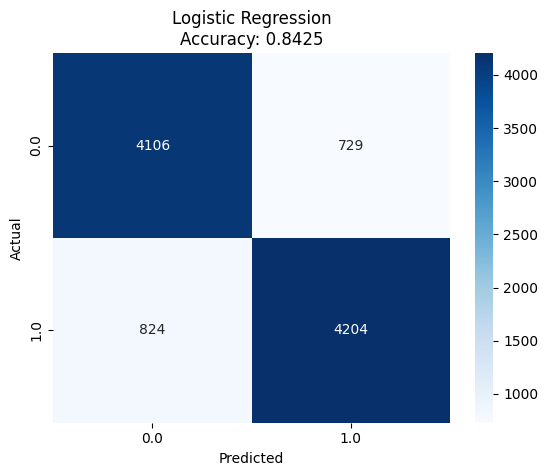

In [ ]:
# Here we run a helper on logistic region and display its confusion matrix.
# Result reflects accuracy and square-wise errors for LR.

v_pr_an_la = v_pr_lr.select("prediction", "label_index").toPandas()
v_cm = pd.crosstab(v_pr_an_la['label_index'], v_pr_an_la['prediction'])
sns.heatmap(v_cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Logistic Regression\nAccuracy: {v_ac_lr:.4f}")  # <-- use v_ac_lr
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()



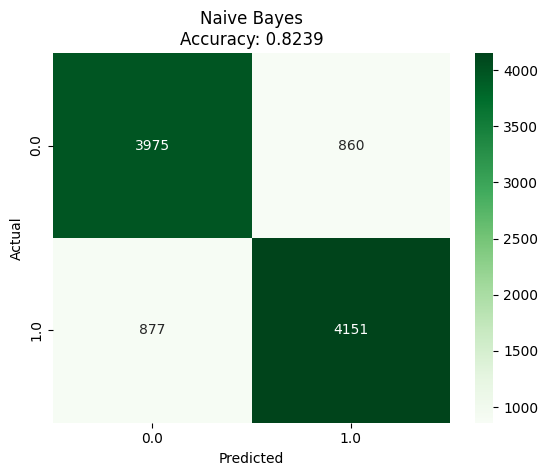

In [ ]:
# The same assessment is repeated for Naive bayes.
# It lets us directly compare NB's strength and weaknesses against LR.

v_pr_an_la = v_pr_nb.select("prediction", "label_index").toPandas()
v_cm = pd.crosstab(v_pr_an_la["label_index"], v_pr_an_la["prediction"])
sns.heatmap(v_cm, annot=True, fmt="d", cmap="Greens")
plt.title(f"Naive Bayes\nAccuracy: {v_ac_nb:.4f}")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()




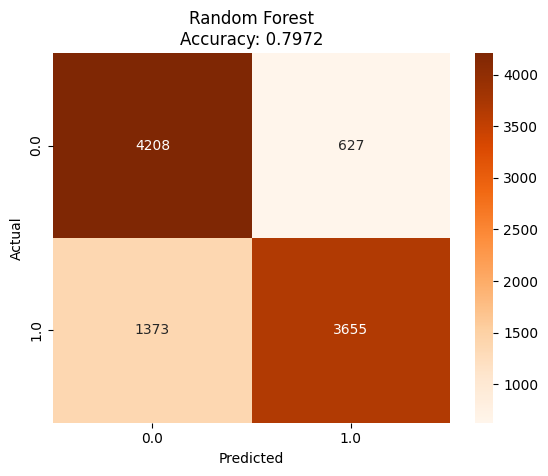

In [ ]:
# Random forest model is further evaluated and its confusion matrix is prepared.
# We can see if tree-based mistakes are different from linear or not.

v_pr_an_la = v_pr_rf.select("prediction", "label_index").toPandas()
v_cm = pd.crosstab(v_pr_an_la["label_index"], v_pr_an_la["prediction"])
sns.heatmap(v_cm, annot=True, fmt="d", cmap="Oranges")
plt.title(f"Random Forest\nAccuracy: {v_ac_rf:.4f}")   # <-- use v_ac_rf
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()


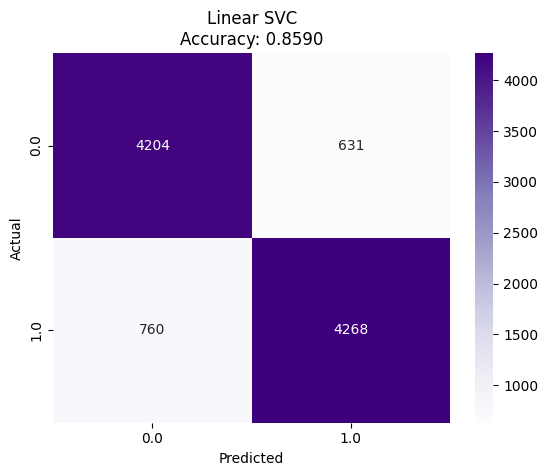

In [ ]:
# Finally we evaluate Linear SVC and display its confusion matrix.
# This completes the set of four classifiers for comparison.

v_pr_an_la = v_pr_sv.select("prediction", "label_index").toPandas()
v_cm = pd.crosstab(v_pr_an_la["label_index"], v_pr_an_la["prediction"])
sns.heatmap(v_cm, annot=True, fmt="d", cmap="Purples")
plt.title(f"Linear SVC\nAccuracy: {v_ac_sv:.4f}")  # <-- use v_ac_sv (not accuracy_svc)
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()


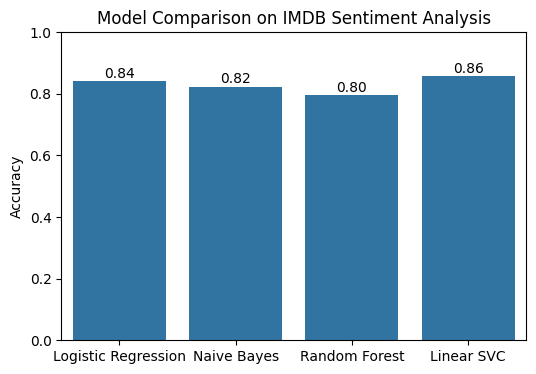

In [ ]:
# Now i collect the accuracy of all models and show them once in the chart.
# A visual comparison quickly helps identify the best performing model.

v_ac2 = {
    "Logistic Regression": v_ac_lr,
    "Naive Bayes":        v_ac_nb,
    "Random Forest":      v_ac_rf,
    "Linear SVC":         v_ac_sv,
}

plt.figure(figsize=(6,4))
ax = sns.barplot(x=list(v_ac2.keys()), y=list(v_ac2.values()))
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Model Comparison on IMDB Sentiment Analysis")
for v_i, v_ac in enumerate(v_ac2.values()):
    plt.text(v_i, v_ac + 0.01, f"{v_ac:.2f}", ha='center')  # <- fixed
plt.show()


In [ ]:
# Preprocessing stages are cached or rebuilt here for reuse.
# This avoids duplication and ensures fair comparison across tuned models.

v_st = [v_to, v_st_re, v_ha, v_id, v_la_in]

In [ ]:
# A result dictionary has been created for each model to store the evaluation score.
# By keeping the results organized, in the end it briefly becomes easier.

v_re = {}

Tuned Logistic Regression Accuracy: 0.8657


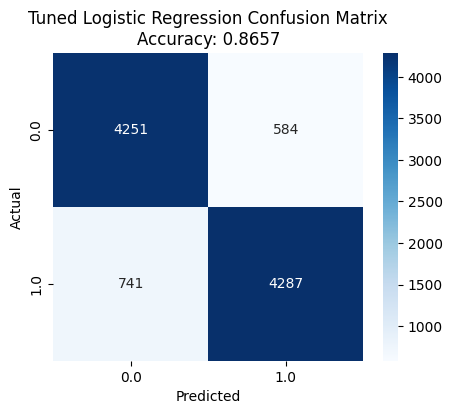

In [ ]:
# TrainValidationSplit is applied to logistic region with parameter grid.
# This light tuning can promote accuracy by finding better regularization values.

# ---- LR tuning (fixed imports + consistent names) ----
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Use your existing preprocessing stages list
try:
    v_st
except NameError:
    # if you called it v_pi_st earlier, use that
    v_st = v_pi_st  # or: v_st = [v_to, v_rm, v_tf, v_id, v_si]

# Evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index", predictionCol="prediction", metricName="accuracy"
)

# Model + param grid
v_lr_tu = LogisticRegression(featuresCol="features", labelCol="label_index", maxIter=20)
v_pa2 = (ParamGridBuilder()
         .addGrid(v_lr_tu.regParam, [0.01, 0.05, 0.1])
         .addGrid(v_lr_tu.elasticNetParam, [0.0, 0.5, 1.0])
         .build())

# Train-validation split
v_tv = TrainValidationSplit(
    estimator=Pipeline(stages=v_st + [v_lr_tu]),
    estimatorParamMaps=v_pa2,
    evaluator=evaluator,
    trainRatio=0.8,
    parallelism=2
)

# Fit + evaluate (uses your train/test DataFrames)
v_tu_mo = v_tv.fit(v_tr_da)
v_pr_lr_tu = v_tu_mo.transform(v_te_da)
v_ac_lr_tu = evaluator.evaluate(v_pr_lr_tu)
print(f"Tuned Logistic Regression Accuracy: {v_ac_lr_tu:.4f}")

# Confusion matrix plot
v_pr_an_la = v_pr_lr_tu.select("prediction", "label_index").toPandas()
v_cm = pd.crosstab(v_pr_an_la['label_index'], v_pr_an_la['prediction'])

plt.figure(figsize=(5,4))
sns.heatmap(v_cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Tuned Logistic Regression Confusion Matrix\nAccuracy: {v_ac_lr_tu:.4f}")  # <- use v_ac_lr_tu
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()


In [ ]:
# Here we tune random forest using a train velidationplate and a small grid.
#The depth and adjusting the parameters of the tree can improve performance on text features.

from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier

evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index", predictionCol="prediction", metricName="accuracy"
)

v_tr_da_sm = v_tr_da.sample(False, 0.2, seed=42)  # 20% of training data

v_rf = RandomForestClassifier(featuresCol="features", labelCol="label_index", numTrees=50)
v_pa_rf = ParamGridBuilder().addGrid(v_rf.maxDepth, [5, 10]).build()

v_tv_rf = TrainValidationSplit(
    estimator=Pipeline(stages=v_st + [v_rf]),
    estimatorParamMaps=v_pa_rf,
    evaluator=evaluator,
    trainRatio=0.8,
    parallelism=1
)

v_rf_mo_tu = v_tv_rf.fit(v_tr_da_sm)
v_pr_rf_tu = v_rf_mo_tu.transform(v_te_da)
v_ac_rf_tu = evaluator.evaluate(v_pr_rf_tu)
print("Tuned Random Forest Accuracy:", v_ac_rf_tu)


Tuned Random Forest Accuracy: 0.7966136064077867


In [ ]:
# Linear SVC is further tuned with separate regularization parameters.
# Proper tuning is important because SVM margin classification affects accuracy.

v_sv = LinearSVC(featuresCol="features", labelCol="label_index", maxIter=20)
v_pa_sv = ParamGridBuilder().addGrid(v_sv.regParam, [0.01, 0.1]).build()

v_tv_sv = TrainValidationSplit(
    estimator=Pipeline(stages=v_st + [v_sv]),
    estimatorParamMaps=v_pa_sv,
    evaluator=evaluator,
    trainRatio=0.8,
    parallelism=1
)

v_sv_mo_tu = v_tv_sv.fit(v_tr_da_sm)
v_pr_sv_tu = v_sv_mo_tu.transform(v_te_da)
v_ac_sv_tu = evaluator.evaluate(v_pr_sv_tu)
print("Tuned Linear SVC Accuracy:", v_ac_sv_tu)

Tuned Linear SVC Accuracy: 0.8246983676366217


In [ ]:
# NAIVE BAYES Smuthing Parameter is tuned here.
# It controls how unseen words are handled and can stabilize predis's.

# Naive Bayes
v_nb = NaiveBayes(featuresCol="features", labelCol="label_index")
v_pa_nb = ParamGridBuilder().addGrid(v_nb.smoothing, [0.5, 1.0]).build()

v_tv_nb = TrainValidationSplit(
    estimator=Pipeline(stages=v_st + [v_nb]),
    estimatorParamMaps=v_pa_nb,
    evaluator=evaluator,
    trainRatio=0.8,
    parallelism=1
)

v_nb_mo_tu = v_tv_nb.fit(v_tr_da_sm)
v_pr_nb_tu = v_nb_mo_tu.transform(v_te_da)
v_ac_nb_tu = evaluator.evaluate(v_pr_nb_tu)
print("Tuned Naive Bayes Accuracy:", v_ac_nb_tu)

Tuned Naive Bayes Accuracy: 0.8094900131805739


{'Random Forest': None, 'Linear SVC': None, 'Naive Bayes': None}


In [ ]:
!pip install nbconvert


In [ ]:
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls "/content/drive/MyDrive/"


In [ ]:
!jupyter nbconvert "/content/drive/MyDrive/Colab Notebooks/Untitled14.ipynb" --to html
